# Operations

### Librarias utilizadas

In [135]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from shapely.geometry import Point
import warnings
from rasterio.sample import sample_gen
warnings.filterwarnings("ignore", category=RuntimeWarning)


### Se carga el set de datos

In [136]:
ruta="/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG"

In [137]:
# Poligono de La Union
union=gpd.read_file(ruta+"/data/data_poligono/la_union.shp")
# Dataset de parcelas
parc=gpd.read_file(ruta+"/data/data_parcelas/parcelas.shp")
# Dataset de mineria
miner=gpd.read_file(ruta+"/data/data_mineria/mineria.shp")
# Dataset de suelos
soil=gpd.read_file(ruta+"/data/data_suelos/suelos.shp")
# Dataset de vocacion
voca=gpd.read_file(ruta+"/data/data_vocacion/vocacion.shp")
# Raster de elevación
elev_path=ruta+'/data/elevation.tif'
# Dataset de vias
vias = gpd.read_file(ruta+"/data/data_vias/vias.shp")
# Raster de temperatura media anual
temp_path=ruta+'/data/data_clima/temp.tif'
# Raster de precipitacion media anual
prec_path=ruta+'/data/data_clima/prec.tif'
# Raster de radiacion media anual
rad_path=ruta+'/data/data_clima/rad.tif'
# Raster de vapor medio anual
vap_path=ruta+'/data/data_clima/vap.tif'
# Raster de velocidad del viento media anual
wind_path=ruta+'/data/data_clima/wind.tif'
# Raster de pH
ph_path=ruta+'/data/data_clima/ph.tif'
# Raster de profundidad efectiva
prof_path=ruta+'/data/data_clima/prof.tif'

### Afectación Minera de cada parcela

/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_1508/1171404972.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  affected_parc = parc[parc.geometry.intersects(mineria_buffered_gdf.unary_union)]
/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_1508/1171404972.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


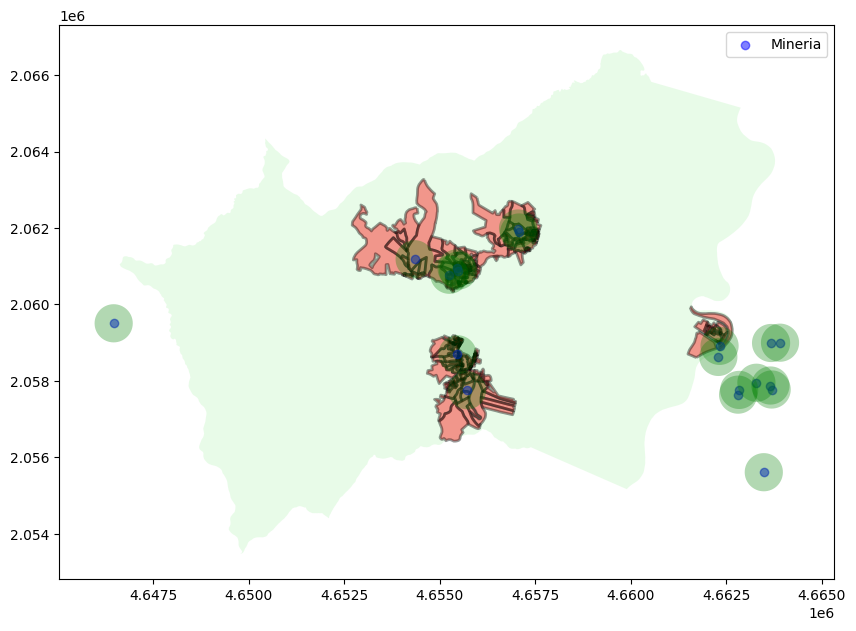

In [138]:
if parc.crs != miner.crs:
    parc = parc.to_crs(miner.crs)
# Se hace un buffer para los puntos de mineria
mineria_buffered=miner.buffer(500)
# Los puntos con buffer son guardados como Geodataframe
mineria_buffered_gdf = gpd.GeoDataFrame(geometry=mineria_buffered)
# Se seleccionan solo aquellas parcelas que se intersecan con las zonas (buffer) de mineria
affected_parc = parc[parc.geometry.intersects(mineria_buffered_gdf.unary_union)]
# Se exporta el archivo a la carpeta results 
affected_parc.to_file(ruta+"/results/miner_parc.geojson", driver="GeoJSON")
# Se grafican aquellos predios afectados junto a los puntos donde hay mineria
fig, ax = plt.subplots(figsize=(10, 10))
union.plot(ax=ax, color='lightgreen', alpha=0.2, label='Municipio')
affected_parc.plot(ax=ax, color='red', edgecolor='black', linewidth=2, alpha=0.4, label='Predios Afectados')
miner.plot(ax=ax, color='blue', alpha=0.5, label='Mineria')
mineria_buffered.plot(ax=ax, color='green', alpha=0.3, label='Buffer Zone')

plt.legend()
plt.show()

### Pendiente de cada parcela

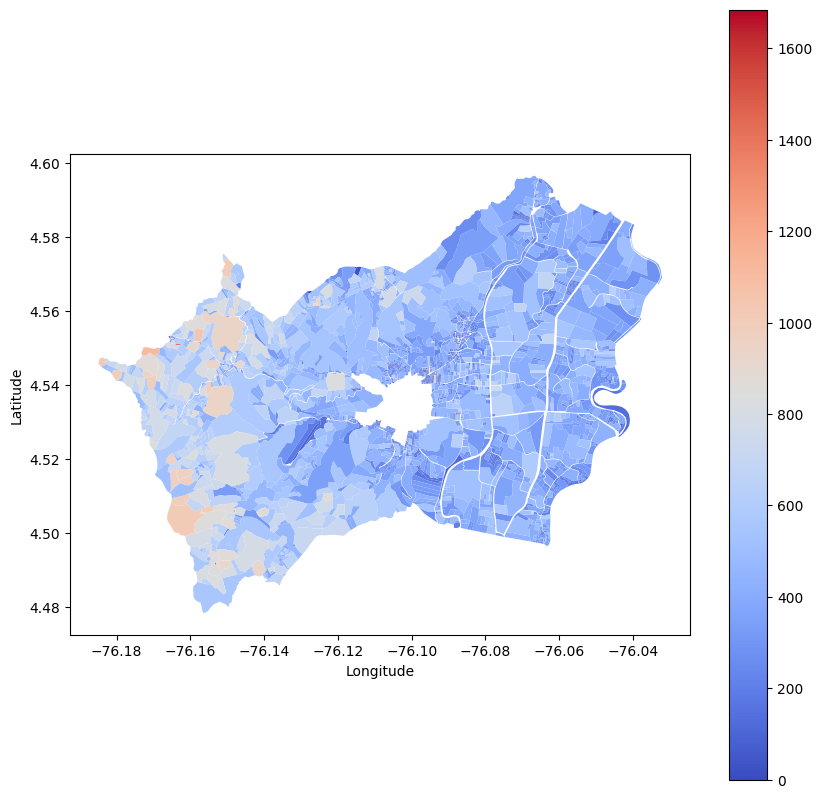

In [139]:
# Se abre la imagen y se lee la primera banda (elevacion)
with rasterio.open(elev_path) as src:
    elev=src.read(1)
    dx, dy = np.gradient(elev)
    # Se calcula la pendiente
    slope = np.arctan(np.sqrt(dx**2 + dy**2)) * (180 / np.pi)

    slopes = []
    # Se igualan los sistemas de coordenadas de ambos elementos
    if parc.crs != src.crs:
        parc = parc.to_crs(src.crs)
    # Se extrae el valor de pendiente para cada predio
    for i,row in parc.iterrows():
        geom = row['geometry']
        geom_json = [geom.__geo_interface__]
        out_image, out_transform = mask(src, geom_json, crop=True)
        valid_values = out_image[~np.isnan(out_image)]
        avg_slope = valid_values.mean() if valid_values.size > 0 else None
        slopes.append(avg_slope)
# Se guarda la informacion de los predios junto al atributo slope que contiene la pendiente de cada uno
slope_parc=parc
slope_parc['slope']=slopes
slope_parc.to_file(ruta+"/results/slope_parc.geojson", driver="GeoJSON")

fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'slope'
slope_parc.plot(column='slope', ax=ax, legend=True,
                           cmap='coolwarm')  

# Agregar título y etiquetas si es necesario

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Mostrar el gráfico
plt.show()

### Vocación de cada parcela

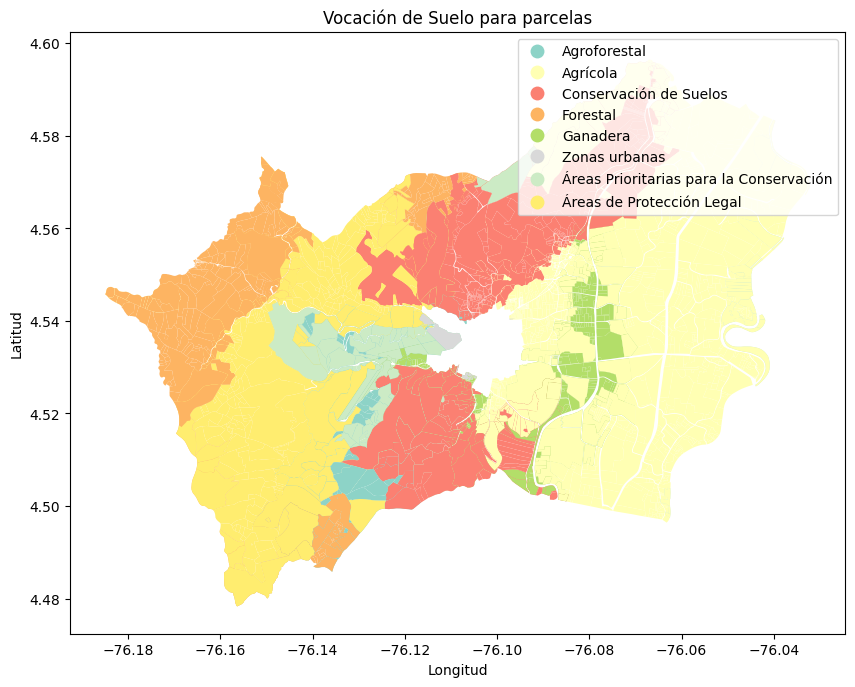

In [140]:
# Se igualan los sistemas de coordenadas
if parc.crs != voca.crs:
    voca = voca.to_crs(parc.crs)

voca_parc = gpd.sjoin(parc, voca, how="left", predicate="intersects")

voca_parc.to_file(ruta+"/results/voca_parc.geojson", driver="GeoJSON")

fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'Vocacion'
voca_parc.plot(column='Vocacion', ax=ax, legend=True,
                           cmap='Set3')  

# Agregar título y etiquetas si es necesario
ax.set_title("Vocación de Suelo para parcelas")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

# Mostrar el gráfico
plt.show()


### Propiedades edafoclimaticas de cada parcela

#### Temperatura Media

/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_1508/3634445108.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = [(point.x, point.y) for point in parc.geometry.centroid]


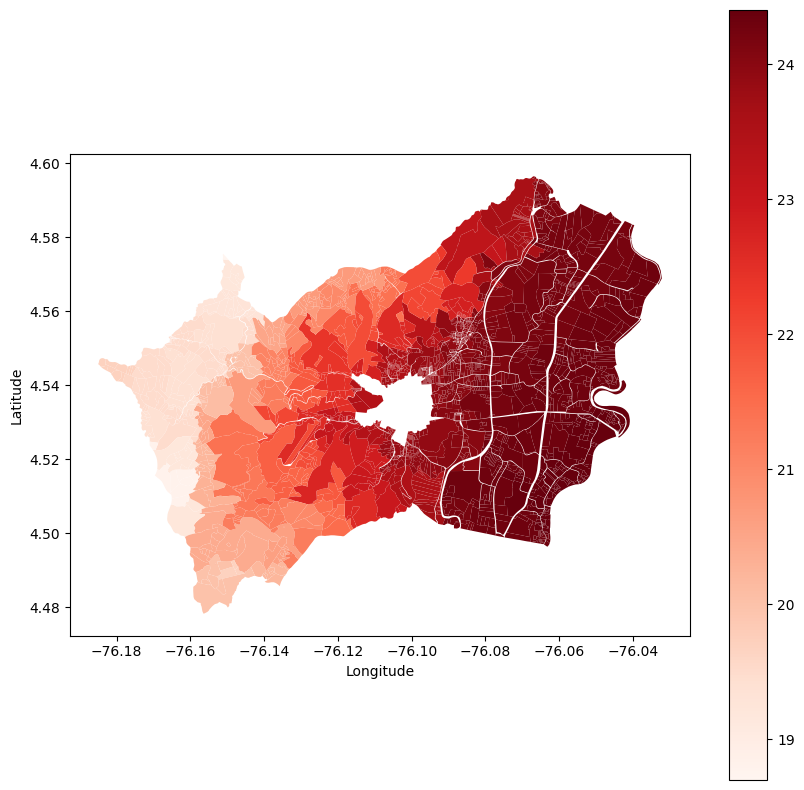

In [141]:
# Obtener centroides como lista de coordenadas
coords = [(point.x, point.y) for point in parc.geometry.centroid]

# Cargar ráster y obtener valores en esas coordenadas
with rasterio.open(temp_path) as src:
    values = [x[0] for x in src.sample(coords)]

temp_parc=parc
temp_parc['temp']=values
temp_parc.to_file(ruta+"/results/temp_parc.geojson", driver="GeoJSON")

fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'Temperatura'
temp_parc.plot(column='temp', ax=ax, legend=True,
                           cmap='Reds')  

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


#### Radiación Media

/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_1508/2908647357.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = [(point.x, point.y) for point in parc.geometry.centroid]


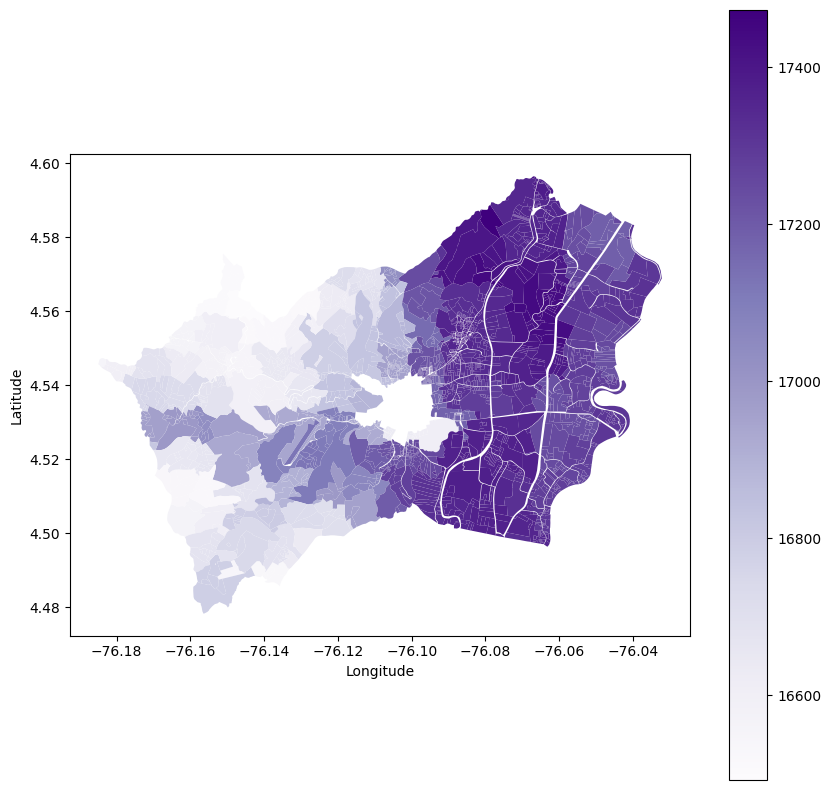

In [142]:
# Obtener centroides como lista de coordenadas
coords = [(point.x, point.y) for point in parc.geometry.centroid]

# Cargar ráster y obtener valores en esas coordenadas
with rasterio.open(rad_path) as src:
    values = [x[0] for x in src.sample(coords)]

rad_parc=parc
rad_parc['rad']=values
rad_parc.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/rad_parc.geojson", driver="GeoJSON")

fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'Radiacion'
rad_parc.plot(column='rad', ax=ax, legend=True,
                           cmap='Purples')  

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

#### Velocidad del viento promedio

/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_1508/4253772800.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = [(point.x, point.y) for point in parc.geometry.centroid]


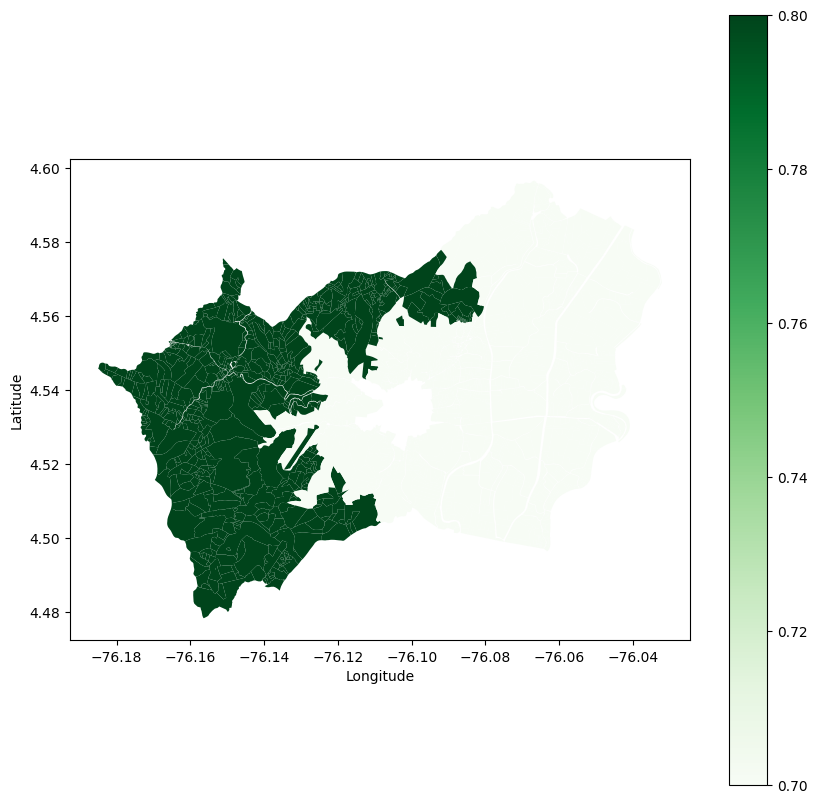

In [143]:
# Obtener centroides como lista de coordenadas
coords = [(point.x, point.y) for point in parc.geometry.centroid]

# Cargar ráster y obtener valores en esas coordenadas
with rasterio.open(wind_path) as src:
    values = [x[0] for x in src.sample(coords)]

wind_parc=parc
wind_parc['wind']=values
wind_parc.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/wind_parc.geojson", driver="GeoJSON")

fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'Velocidad del viento'
wind_parc.plot(column='wind', ax=ax, legend=True,
                           cmap='Greens')  

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

#### Precipitación Promedio

/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_1508/1341543861.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = [(point.x, point.y) for point in parc.geometry.centroid]


<function matplotlib.pyplot.show(close=None, block=None)>

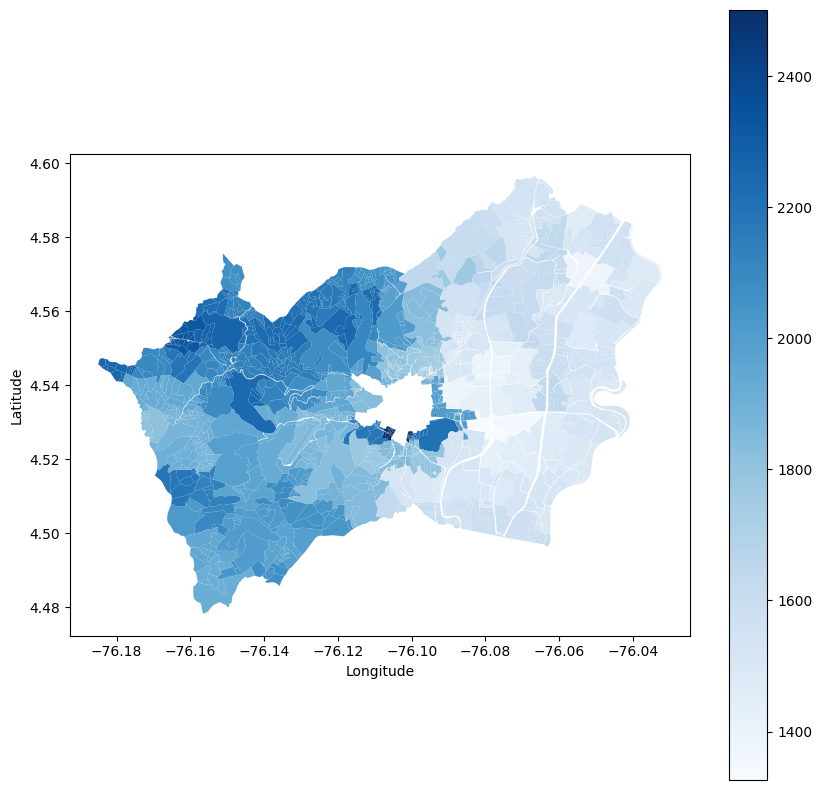

In [144]:
# Obtener centroides como lista de coordenadas
coords = [(point.x, point.y) for point in parc.geometry.centroid]

# Cargar ráster y obtener valores en esas coordenadas
with rasterio.open(prec_path) as src:
    values = [x[0] for x in src.sample(coords)]

prec_parc=parc
prec_parc['prec']=values
prec_parc.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/prec_parc.geojson", driver="GeoJSON")

fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'Precipitación'
prec_parc.plot(column='prec', ax=ax, legend=True,
                           cmap='Blues')  

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show

#### Vapor de agua

/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_1508/2801167601.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = [(point.x, point.y) for point in parc.geometry.centroid]


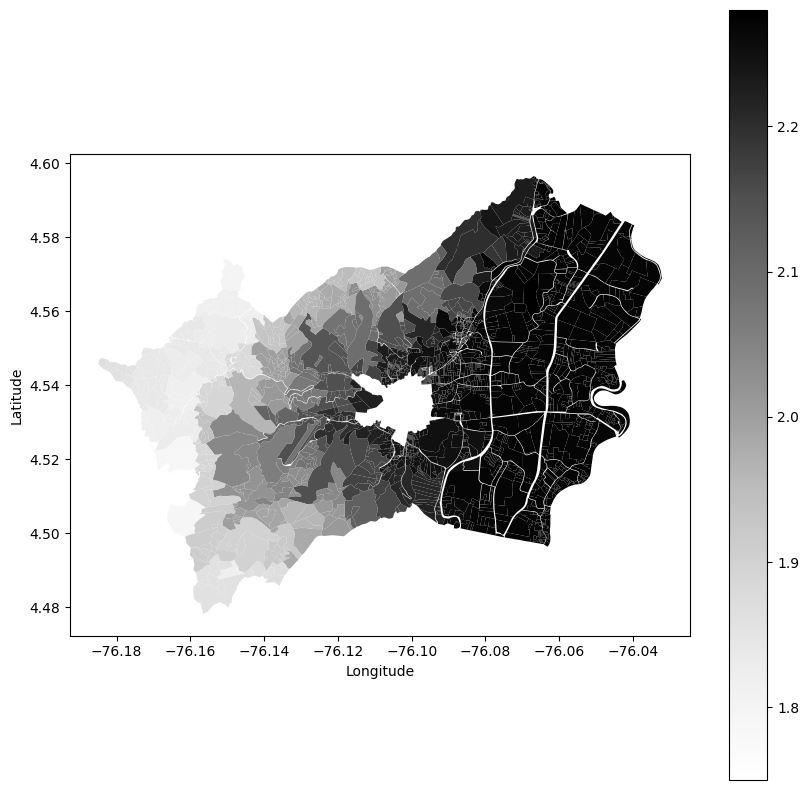

In [145]:
# Obtener centroides como lista de coordenadas
coords = [(point.x, point.y) for point in parc.geometry.centroid]

# Cargar ráster y obtener valores en esas coordenadas
with rasterio.open(vap_path) as src:
    values = [x[0] for x in src.sample(coords)]

vap_parc=parc
vap_parc['vap']=values
vap_parc.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/vap_parc.geojson", driver="GeoJSON")

fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'Presion de vapor'
vap_parc.plot(column='vap', ax=ax, legend=True,
                           cmap='Grays')  

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

#### pH

/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_1508/997188275.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = [(point.x, point.y) for point in parc.geometry.centroid]


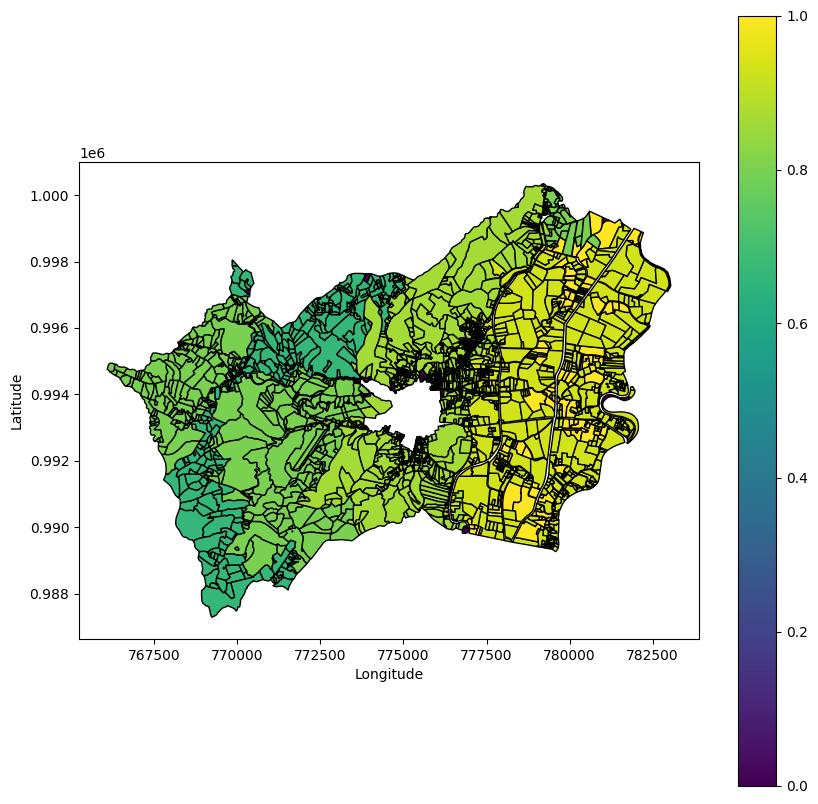

In [146]:
# Obtener centroides como lista de coordenadas
parc = parc.to_crs("EPSG:4326")  # Asegura que las parcelas tengan un CRS adecuado
coords = [(point.x, point.y) for point in parc.geometry.centroid]

# Cargar ráster y obtener valores en esas coordenadas
with rasterio.open(ph_path) as src:
    # Reproyectar parcelas al CRS del ráster si es necesario
    if parc.crs != src.crs:
        parc = parc.to_crs(src.crs)
        coords = [(point.x, point.y) for point in parc.geometry.centroid]

    # Extraer valores del ráster
    values = [x[0] if x is not None else np.nan for x in src.sample(coords)]
    
    # Convertir NoData (-9999, NaN, etc.) a NaN
    values = [v if v != src.nodata else np.nan for v in values]

# Agregar los valores extraídos al GeoDataFrame
ph_parc = parc.copy()
ph_parc['ph'] = values

# Normalizar los valores para mejorar la visualización
if not all(np.isnan(values)) and (np.nanmax(values) - np.nanmin(values)) > 0:
    ph_parc['ph'] = (ph_parc['ph'] - np.nanmin(values)) / (np.nanmax(values) - np.nanmin(values))

# Guardar el resultado en un archivo GeoJSON
ph_parc.to_file(ruta+"/results/ph_parc.geojson", driver="GeoJSON")

# Crear la figura
fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'ph'
ph_parc.plot(column='ph', ax=ax, legend=True, cmap='viridis', edgecolor="black")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

#### Profundidad efectiva del suelo

/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_1508/2464971496.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = [(point.x, point.y) for point in parc.geometry.centroid]


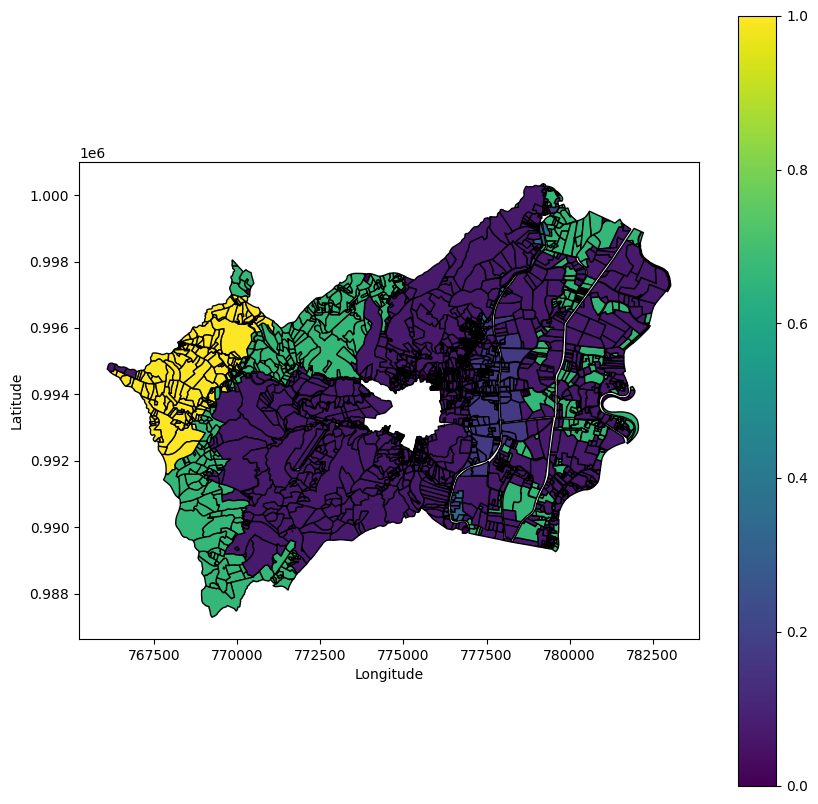

In [147]:

# Obtener centroides como lista de coordenadas
parc = parc.to_crs("EPSG:4326")  # Asegura que las parcelas tengan un CRS adecuado
coords = [(point.x, point.y) for point in parc.geometry.centroid]

# Cargar ráster y obtener valores en esas coordenadas
with rasterio.open(prof_path) as src:
    # Reproyectar parcelas al CRS del ráster si es necesario
    if parc.crs != src.crs:
        parc = parc.to_crs(src.crs)
        coords = [(point.x, point.y) for point in parc.geometry.centroid]

    # Extraer valores del ráster
    values = [x[0] if x is not None else np.nan for x in src.sample(coords)]
    
    # Convertir NoData (-9999, NaN, etc.) a NaN
    values = [v if v != src.nodata else np.nan for v in values]

# Agregar los valores extraídos al GeoDataFrame
prof_parc = parc.copy()
prof_parc['prof'] = values


# Normalizar los valores para mejorar la visualización
if not all(np.isnan(values)) and (np.nanmax(values) - np.nanmin(values)) > 0:
   prof_parc['prof'] = ( prof_parc['prof'] - np.nanmin(values)) / (np.nanmax(values) - np.nanmin(values))

# Guardar el resultado en un archivo GeoJSON
prof_parc.to_file(ruta+"/results/prof_parc.geojson", driver="GeoJSON")

# Crear la figura
fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'ph'
prof_parc.plot(column='prof', ax=ax, legend=True, cmap='viridis', edgecolor="black")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

### Distancia a via principal de cada parcela

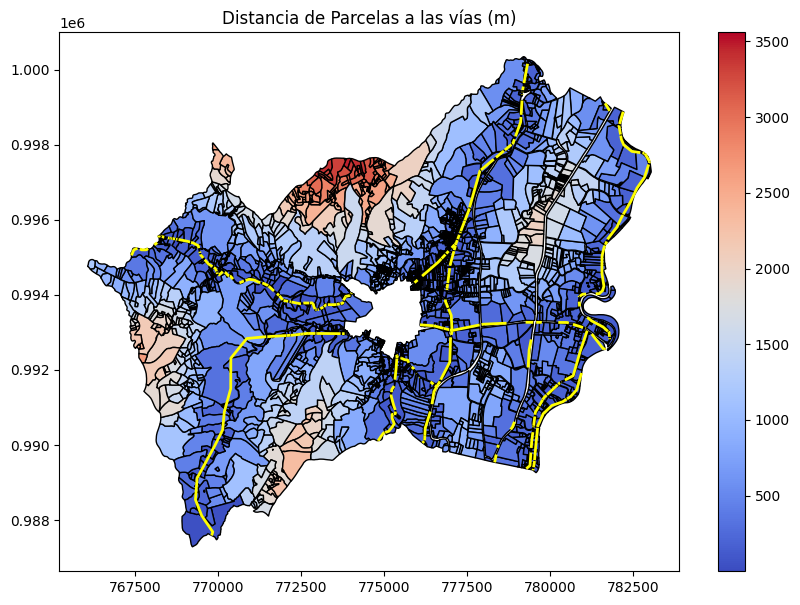

In [148]:
# Convertir a un CRS proyectado para Colombia (Magna-SIRGAS / UTM zona 18N - EPSG:3116)
parc = parc.to_crs("EPSG:3116")
vias = vias.to_crs("EPSG:3116")

new_parc=parc
# Obtener el centroide de cada parcela
new_parc['centroide'] = new_parc.geometry.centroid

# Calcular la distancia desde cada centroide de parcela a la vía más cercana
new_parc['distancia_a_via'] = new_parc['centroide'].apply(lambda geom: vias.geometry.distance(geom).min())

# Crear un nuevo GeoDataFrame con las parcelas y las distancias
parc_con_distancia = new_parc.drop(columns=['centroide'])

# Guardar el resultado en un nuevo archivo
parc_con_distancia.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/dist_parc.geojson", driver="GeoJSON")

# Generar el mapa
fig, ax = plt.subplots(figsize=(10, 7))
cbar = parc_con_distancia.plot(column='distancia_a_via', cmap='coolwarm', legend=True, ax=ax, edgecolor='black')
vias.plot(color='yellow', linewidth=2, ax=ax)
ax.set_title("Distancia de Parcelas a las vías (m)")
ax.set_aspect('auto')  # Ajustar el aspecto para evitar errores

# Mostrar el gráfico
plt.show()

# Limpieza Variables Edafoclimaticas

In [149]:
ph=gpd.read_file(ruta+"/results/ph_parc.geojson")
prec=gpd.read_file(ruta+"/results/prec_parc.geojson")
prof=gpd.read_file(ruta+"/results/prof_parc.geojson")
rad=gpd.read_file(ruta+"/results/rad_parc.geojson")
temp=gpd.read_file(ruta+"/results/temp_parc.geojson")
vap=gpd.read_file(ruta+"/results/vap_parc.geojson")
wind=gpd.read_file(ruta+"/results/wind_parc.geojson")
slope=gpd.read_file(ruta+"/results/slope_parc.geojson")

In [150]:
# Seleccionar columnas sin duplicar 'geometry' en las uniones
ph = ph[['CODIGO', 'ph', 'geometry']]
prec = prec[['CODIGO', 'prec']]
prof = prof[['CODIGO', 'prof']]
rad = rad[['CODIGO', 'rad']]
temp = temp[['CODIGO', 'temp']]
vap = vap[['CODIGO', 'vap']]
wind = wind[['CODIGO', 'wind']]
slope= slope[['CODIGO', 'slope']]

# Unir los DataFrames progresivamente usando 'CODIGO' como clave
edafoclima_gdf = ph.merge(prec, on='CODIGO', how='outer')\
                   .merge(prof, on='CODIGO', how='outer')\
                   .merge(rad, on='CODIGO', how='outer')\
                   .merge(temp, on='CODIGO', how='outer')\
                   .merge(vap, on='CODIGO', how='outer')\
                   .merge(wind, on='CODIGO', how='outer')\
                   .merge(slope, on='CODIGO', how='outer')

# Asegurar que el GeoDataFrame mantiene su geometría
edafoclima_gdf = gpd.GeoDataFrame(edafoclima_gdf, geometry='geometry')
edafoclima_gdf["x"] = edafoclima_gdf.centroid.x
edafoclima_gdf["y"] = edafoclima_gdf.centroid.y
# Guardar el resultado en un archivo GeoJSON
edafoclima_gdf.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/edafoclima.geojson", driver="GeoJSON")


# Mostrar los primeros registros para verificar
edafoclima_gdf.head()


,CODIGO,ph,geometry,prec,prof,rad,temp,vap,wind,slope,x,y
0,764000001000000010001000000000,0.933333,"POLYGON ((781207.87 992989.278, 781192.794 992...",1538.0,0.066667,17307.166,24.4,2.27,0.7,303.333333,781176.414750,992980.226873
1,764000001000000010002000000000,0.933333,"POLYGON ((781144.84 992314.853, 781114.773 992...",1538.0,0.066667,17307.166,24.4,2.27,0.7,438.317308,781275.173138,992625.887158
2,764000001000000010007000000000,0.933333,"POLYGON ((781082.069 992336.105, 781075.362 99...",1502.0,0.066667,17275.584,24.4,2.27,0.7,259.928571,780986.343350,992356.579221
3,764000001000000010010000000000,0.933333,"POLYGON ((781058.832 992318.004, 781035.422 99...",1502.0,0.666667,17275.584,24.4,2.27,0.7,333.700000,780977.734743,992304.961733
4,764000001000000010011000000000,0.933333,"POLYGON ((781144.84 992314.853, 781138.6 99230...",1502.0,0.666667,17275.584,24.4,2.27,0.7,302.538462,780946.127711,992155.054198


# Analisis clusters creados

### Unión de dataframes

In [151]:
ph=gpd.read_file(ruta+"/results/ph_parc.geojson")
prec=gpd.read_file(ruta+"/results/prec_parc.geojson")
prof=gpd.read_file(ruta+"/results/prof_parc.geojson")
rad=gpd.read_file(ruta+"/results/rad_parc.geojson")
temp=gpd.read_file(ruta+"/results/temp_parc.geojson")
slope=gpd.read_file(ruta+"/results/slope_parc.geojson")
cluster=gpd.read_file(ruta+"/results/clusters.csv")
# Seleccionar columnas sin duplicar 'geometry' en las uniones
ph = ph[['CODIGO', 'ph', 'geometry']]
prec = prec[['CODIGO', 'prec']]
prof = prof[['CODIGO', 'prof']]
rad = rad[['CODIGO', 'rad']]
temp = temp[['CODIGO', 'temp']]
slope= slope[['CODIGO', 'slope']]
cluster = cluster[['CODIGO', 'clust']]


all_gdf = ph.merge(prec, on='CODIGO', how='outer')\
                   .merge(prof, on='CODIGO', how='outer')\
                   .merge(rad, on='CODIGO', how='outer')\
                   .merge(temp, on='CODIGO', how='outer')\
                   .merge(slope, on='CODIGO', how='outer')\
                   .merge(cluster, on='CODIGO', how='outer')

all_gdf=all_gdf.groupby('CODIGO', as_index=False).agg({
    'ph': 'mean',
    'geometry': 'first',  # Mantiene la primera geometría encontrada
    'prec': 'mean',
    'prof': 'mean',
    'rad': 'mean',
    'temp': 'mean',
    'slope': 'mean',
    'clust': lambda x: x.mode().iat[0] 
})
all_gdf.head(5)


,CODIGO,ph,geometry,prec,prof,rad,temp,slope,clust
0,764000001000000010001000000000,0.933333,"POLYGON ((781207.87 992989.278, 781192.794 992...",1538.0,0.066667,17307.166,24.4,303.333333,1
1,764000001000000010002000000000,0.933333,"POLYGON ((781144.84 992314.853, 781114.773 992...",1538.0,0.066667,17307.166,24.4,438.317308,1
2,764000001000000010007000000000,0.933333,"POLYGON ((781082.069 992336.105, 781075.362 99...",1502.0,0.066667,17275.584,24.4,259.928571,1
3,764000001000000010010000000000,0.933333,"POLYGON ((781058.832 992318.004, 781035.422 99...",1502.0,0.666667,17275.584,24.4,333.700000,1
4,764000001000000010011000000000,0.933333,"POLYGON ((781144.84 992314.853, 781138.6 99230...",1502.0,0.666667,17275.584,24.4,302.538462,1


In [152]:
all_gdf['ph'] = all_gdf['ph'] * 7.5
all_gdf['prof'] = all_gdf['prof'] * 1.5
all_gdf['rad'] = all_gdf['rad'] / 2000
all_gdf['slope']=(all_gdf['slope'] / 2000) * 100

In [153]:
all_gdf

,CODIGO,ph,geometry,prec,prof,rad,temp,slope,clust
0,764000001000000010001000000000,7.0,"POLYGON ((781207.87 992989.278, 781192.794 992...",1538.0,0.1,8.653583,24.4,15.166667,1
1,764000001000000010002000000000,7.0,"POLYGON ((781144.84 992314.853, 781114.773 992...",1538.0,0.1,8.653583,24.4,21.915865,1
2,764000001000000010007000000000,7.0,"POLYGON ((781082.069 992336.105, 781075.362 99...",1502.0,0.1,8.637792,24.4,12.996429,1
3,764000001000000010010000000000,7.0,"POLYGON ((781058.832 992318.004, 781035.422 99...",1502.0,1.0,8.637792,24.4,16.685000,1
4,764000001000000010011000000000,7.0,"POLYGON ((781144.84 992314.853, 781138.6 99230...",1502.0,1.0,8.637792,24.4,15.126923,1
...,...,...,...,...,...,...,...,...,...
4617,764000002000000040340000000000,6.0,"POLYGON ((767454.819 994549.903, 767447.443 99...",2102.0,1.5,8.342917,19.5,30.322449,5
4618,764000002000000040341000000000,6.0,"POLYGON ((768464.877 993080.27, 768529.969 993...",1873.0,1.5,8.495167,19.5,32.043333,5
4619,764000002000000040342000000000,5.0,"POLYGON ((769476.69 994197.213, 769476.6 99417...",2088.0,1.0,8.342750,20.1,49.886813,5
4620,764000002000000040343000000000,6.0,"POLYGON ((770161.979 996703.153, 770161.725 99...",2132.0,1.5,8.246042,19.3,32.142614,5


In [154]:
mineria=gpd.read_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/miner_parc.geojson")

df_filtrado = all_gdf.merge(mineria[['CODIGO']], on='CODIGO', how='left', indicator=True)

# Filtrar solo los registros que no coinciden con df2
df_filtrado = df_filtrado[df_filtrado['_merge'] == 'left_only'].drop(columns=['_merge'])

# Mostrar resultado
df_filtrado.head(5)

,CODIGO,ph,geometry,prec,prof,rad,temp,slope,clust
0,764000001000000010001000000000,7.0,"POLYGON ((781207.87 992989.278, 781192.794 992...",1538.0,0.1,8.653583,24.4,15.166667,1
2,764000001000000010007000000000,7.0,"POLYGON ((781082.069 992336.105, 781075.362 99...",1502.0,0.1,8.637792,24.4,12.996429,1
3,764000001000000010010000000000,7.0,"POLYGON ((781058.832 992318.004, 781035.422 99...",1502.0,1.0,8.637792,24.4,16.685000,1
4,764000001000000010011000000000,7.0,"POLYGON ((781144.84 992314.853, 781138.6 99230...",1502.0,1.0,8.637792,24.4,15.126923,1
5,764000001000000010012000000000,7.0,"POLYGON ((780962.043 991989.101, 780955.1 9919...",1502.0,0.1,8.637792,24.4,23.375000,1


In [155]:
df_filtrado=df_filtrado[['clust','ph','prof','rad','slope','temp','prec']]
df_grouped = df_filtrado.groupby('clust', as_index=False).mean()

# Mostrar el resultado
print(df_grouped)

  clust        ph      prof       rad      slope       temp         prec
0     1  7.068815  0.351220  8.652698  18.192388  24.260627  1542.648084
1     2  6.508405  0.122478  8.591060   8.617913  23.764361  1778.917387
2     3  0.000000  0.000000  8.551484   6.088423  23.732143  1910.423469
3     4  6.716599  0.502834  8.672764  16.456989  24.024697  1542.469636
4     5  5.502706  0.902165  8.342840  26.968732  20.398376  2090.193505
